In [1]:
from restructure_data import DataRestructuring
from feature_engineer import FeatureEngineering

In [2]:
data = DataRestructuring(df_train_path=r'D:\Gallon\Project\07_E_SUN_2021_Winter_AI\data\tbrain_cc_training_48tags_hash_final.csv',
                    df_test_path=r'D:\Gallon\Project\07_E_SUN_2021_Winter_AI\data\需預測的顧客名單及提交檔案範例.csv',
                    start_index=0,
                    number=1000)
data.execute()

2021-12-21 17:22:48,688-INFO-Start reading test data.
2021-12-21 17:22:49,165-INFO-Test data shape: (1000, 4)
2021-12-21 17:22:49,166-INFO-Finish reading test data.
2021-12-21 17:22:49,166-INFO-Start reading train data.


Iteration is stopped.
Memory usage of dataframe is 17.46 MB


2021-12-21 17:25:33,061-INFO-Finish reading train data.
2021-12-21 17:25:33,070-INFO-Start creating training matrix.


Memory usage after optimization is: 5.36 MB
Decreased by 69.3%
Memory usage of dataframe is 117.92 MB


2021-12-21 17:25:36,477-INFO-Finish creating training matrix.


Memory usage after optimization is: 47.61 MB
Decreased by 59.6%


2021-12-21 17:27:37,793-INFO-Start shop tagging engineering.
2021-12-21 17:27:39,760-INFO-Finish shop tagging engineering.
2021-12-21 17:27:39,760-INFO-Start clustering feature engineering.
2021-12-21 17:27:42,732-INFO-Finish clustering feature engineering.
2021-12-21 17:27:42,733-INFO-Start percentage changing feature engineering.


Adding feature shop_tag_txn_amt_mean_delta_1_lag_1
Adding feature shop_tag_txn_amt_mean_delta_1_lag_12
Adding feature chid_txn_amt_mean_delta_1_lag_1
Adding feature chid_txn_amt_mean_delta_1_lag_12
Adding feature educd_txn_amt_mean_delta_1_lag_1
Adding feature trdtp_txn_amt_mean_delta_1_lag_1
Adding feature gender_code_txn_amt_mean_delta_1_lag_1
Adding feature age_txn_amt_mean_delta_1_lag_1


2021-12-21 17:27:49,026-INFO-Finish percentage changing feature engineering.
2021-12-21 17:27:49,027-INFO-Start rolling feature engineering.


Creating feature "chid_shop_tag_txn_amt_mean_rolling_mean_win_12"
Creating feature "chid_shop_tag_txn_amt_mean_expanding_mean"
Creating feature "chid_shop_tag_txn_amt_mean_ewm_hl_1"
Creating feature "age_shop_tag_txn_amt_mean_rolling_mean_win_12"
Creating feature "age_shop_tag_txn_amt_mean_expanding_mean"
Creating feature "age_shop_tag_txn_amt_mean_ewm_hl_1"
Creating feature "age_gender_code_shop_tag_txn_amt_mean_rolling_mean_win_12"
Creating feature "age_gender_code_shop_tag_txn_amt_mean_expanding_mean"
Creating feature "age_gender_code_shop_tag_txn_amt_mean_ewm_hl_1"


2021-12-21 17:28:07,901-INFO-Finish rolling feature engineering.


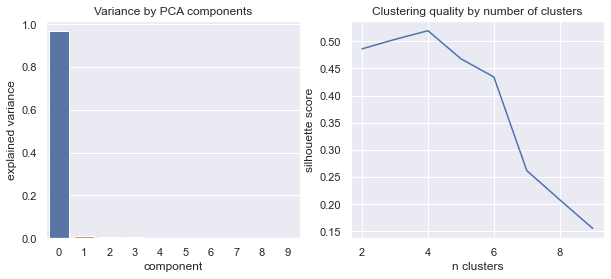

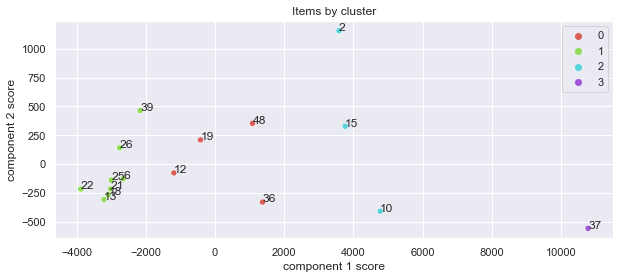

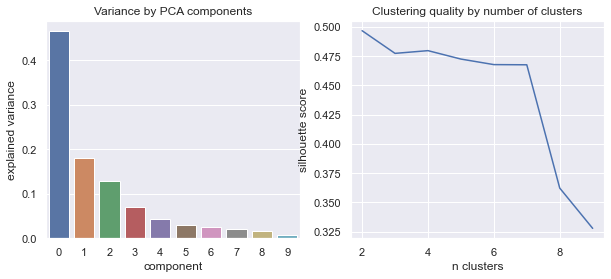

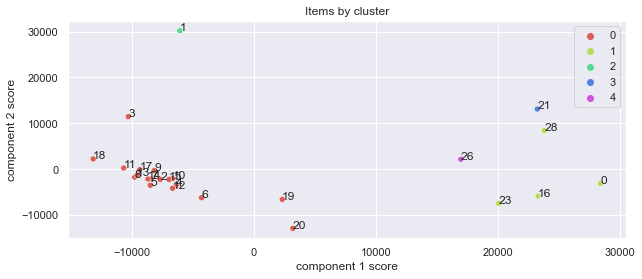

In [3]:
fe = FeatureEngineering(matrix=data.matrix)
fe.execute()

In [5]:
matrix = fe.matrix.copy()

In [7]:
matrix.shape

(384000, 74)

In [10]:
matrix.columns

Index(['dt', 'chid', 'shop_tag', 'txn_cnt', 'txn_amt', 'domestic_offline_cnt',
       'domestic_online_cnt', 'overseas_offline_cnt', 'overseas_online_cnt',
       'domestic_offline_amt_pct', 'domestic_online_amt_pct',
       'overseas_offline_amt_pct', 'overseas_online_amt_pct', 'card_1_txn_cnt',
       'card_2_txn_cnt', 'card_3_txn_cnt', 'card_4_txn_cnt', 'card_5_txn_cnt',
       'card_6_txn_cnt', 'card_7_txn_cnt', 'card_8_txn_cnt', 'card_9_txn_cnt',
       'card_10_txn_cnt', 'card_11_txn_cnt', 'card_12_txn_cnt',
       'card_13_txn_cnt', 'card_14_txn_cnt', 'card_other_txn_cnt',
       'card_1_txn_amt_pct', 'card_2_txn_amt_pct', 'card_3_txn_amt_pct',
       'card_4_txn_amt_pct', 'card_5_txn_amt_pct', 'card_6_txn_amt_pct',
       'card_7_txn_amt_pct', 'card_8_txn_amt_pct', 'card_9_txn_amt_pct',
       'card_10_txn_amt_pct', 'card_11_txn_amt_pct', 'card_12_txn_amt_pct',
       'card_13_txn_amt_pct', 'card_14_txn_amt_pct', 'card_other_txn_amt_pct',
       'masts', 'educd', 'trdtp', 'naty

In [ ]:
def create_apply_ME(
    matrix, grouping_fields, lags=[1], target="txn_amt", aggfunc="mean"
):
    grouping_fields = list_if_not(grouping_fields)
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = (
            matrix.groupby(["date_block_num"] + grouping_fields)[target]
            .agg(aggfunc)
            .rename(newname)
            .reset_index()
        )
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del me_series
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[
                matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
            ] = float("nan")
            del matrix["firsts"]
        matrix[newname] = reduce_mem_usage(matrix[newname])
    return matrix

In [9]:
def simple_lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f"_lag_{lag}"
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ["dt", "chid", "shop_tag"] + [lag_feature]]
        targetseries["dt"] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(
            targetseries, on=["dt", "chid", "shop_tag"], how="left"
        )
        matrix.loc[
            (matrix[newname].isna()),
            newname,
        ] = 0
    return matrix

In [11]:
matrix = simple_lag_feature(matrix, 'txn_amt', lags=[1,2,3])
matrix = simple_lag_feature(matrix, 'txn_cnt', lags=[1, 2, 3])
# gc.collect()
print("Lag features created")

Adding feature txn_amt_lag_1
Adding feature txn_amt_lag_2
Adding feature txn_amt_lag_3
Adding feature txn_cnt_lag_1
Adding feature txn_cnt_lag_2
Adding feature txn_cnt_lag_3
Lag features created
